1) Какие года были самыми прибыльными
2) Какие года были самыми неприбыльными
3) Какие фильмы самые прибыльные
4) Какие фильмы самые неприбыльные
5) Какой режиссер самый успешный (по сборам)
6) Какой режиссер самый успешный (по оценкам)
7) Какие фильмы самый высокооцененные
8) Какие фильмы самый низкооцененные
9) Какие общие признаки у самых прибыльных фильмов
10) Лучшие фильмы в жанре
11) Худшие фильмы в жанре

# Импорт

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 3)

# Чтение датасета

In [3]:
original_df = pd.read_csv('dataset/tmdb_movies_data.csv', on_bad_lines='skip')
original_df

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.3,2015,1.747999e+08,1.385749e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10861,21,tt0060371,0.080598,0,0,The Endless Summer,Michael Hynson|Robert August|Lord 'Tally Ho' B...,NaN,Bruce Brown,NaN,...,"The Endless Summer, by Bruce Brown, is one of ...",95,Documentary,Bruce Brown Films,6/15/1966,11,7.4,1966,0.000000e+00,0.000000e+00
10862,20379,tt0060472,0.065543,0,0,Grand Prix,James Garner|Eva Marie Saint|Yves Montand|Tosh...,NaN,John Frankenheimer,Cinerama sweeps YOU into a drama of speed and ...,...,Grand Prix driver Pete Aron is fired by his te...,176,Action|Adventure|Drama,Cherokee Productions|Joel Productions|Douglas ...,12/21/1966,20,5.7,1966,0.000000e+00,0.000000e+00
10863,39768,tt0060161,0.065141,0,0,Beregis Avtomobilya,Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...,NaN,Eldar Ryazanov,NaN,...,An insurance agent who moonlights as a carthie...,94,Mystery|Comedy,Mosfilm,1/1/1966,11,6.5,1966,0.000000e+00,0.000000e+00
10864,21449,tt0061177,0.064317,0,0,"What's Up, Tiger Lily?",Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...,NaN,Woody Allen,WOODY ALLEN STRIKES BACK!,...,"In comic Woody Allen's film debut, he took the...",80,Action|Comedy,Benedict Pictures Corp.,11/2/1966,22,5.4,1966,0.000000e+00,0.000000e+00


# Очистка от мусорных строк

#### Удаление дубликатов

In [4]:
original_df.duplicated().sum()

1

In [5]:
original_df.drop_duplicates(inplace=True)
original_df.duplicated().sum()

0

In [6]:
original_df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

#### Удаляем пустые строки у тех столбцов, которые будем использовать

In [7]:
original_df = original_df.dropna(subset=['cast', 'director', 'production_companies', 'genres'])

In [8]:
original_df.isnull().sum()

id                         0
imdb_id                    2
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                       0
homepage                7135
director                   0
tagline                 2137
keywords                1106
overview                   0
runtime                    0
genres                     0
production_companies       0
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

# Получение нужных столбцов из исходного DataFrame

In [9]:
desired_columns_df: pd.DataFrame = original_df.drop(columns=['imdb_id', 'homepage', 'budget_adj', 'revenue_adj', 'tagline', 'keywords',
                                                             'overview', 'release_date'])
# отсеивание короткометражных фильмов с маленьким бюджетом
desired_columns_df = desired_columns_df.query('revenue > 10000 and budget > 10000')
desired_columns_df

,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,vote_count,vote_average,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,5562,6.5,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,6185,7.1,2015
2,262500,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2480,6.3,2015
3,140607,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,5292,7.5,2015
4,168259,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2947,7.3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,396,0.670274,7500000,33736689,Who's Afraid of Virginia Woolf?,Elizabeth Taylor|Richard Burton|George Segal|S...,Mike Nichols,131,Drama,Chenault Productions,74,7.5,1966
10828,5780,0.402730,3000000,13000000,Torn Curtain,Paul Newman|Julie Andrews|Lila Kedrova|HansjÃ¶...,Alfred Hitchcock,128,Mystery|Thriller,Universal Pictures,46,6.3,1966
10829,6644,0.395668,4653000,6000000,El Dorado,John Wayne|Robert Mitchum|James Caan|Charlene ...,Howard Hawks,120,Action|Western,Paramount Pictures|Laurel Productions,36,6.9,1966
10835,5923,0.299911,12000000,20000000,The Sand Pebbles,Steve McQueen|Richard Attenborough|Richard Cre...,Robert Wise,182,Action|Adventure|Drama|War|Romance,Twentieth Century Fox Film Corporation|Solar P...,28,7.0,1966


In [10]:
desired_columns_df.isnull().sum()

id                      0
popularity              0
budget                  0
revenue                 0
original_title          0
cast                    0
director                0
runtime                 0
genres                  0
production_companies    0
vote_count              0
vote_average            0
release_year            0
dtype: int64

In [11]:
desired_columns_df.duplicated().sum()

0

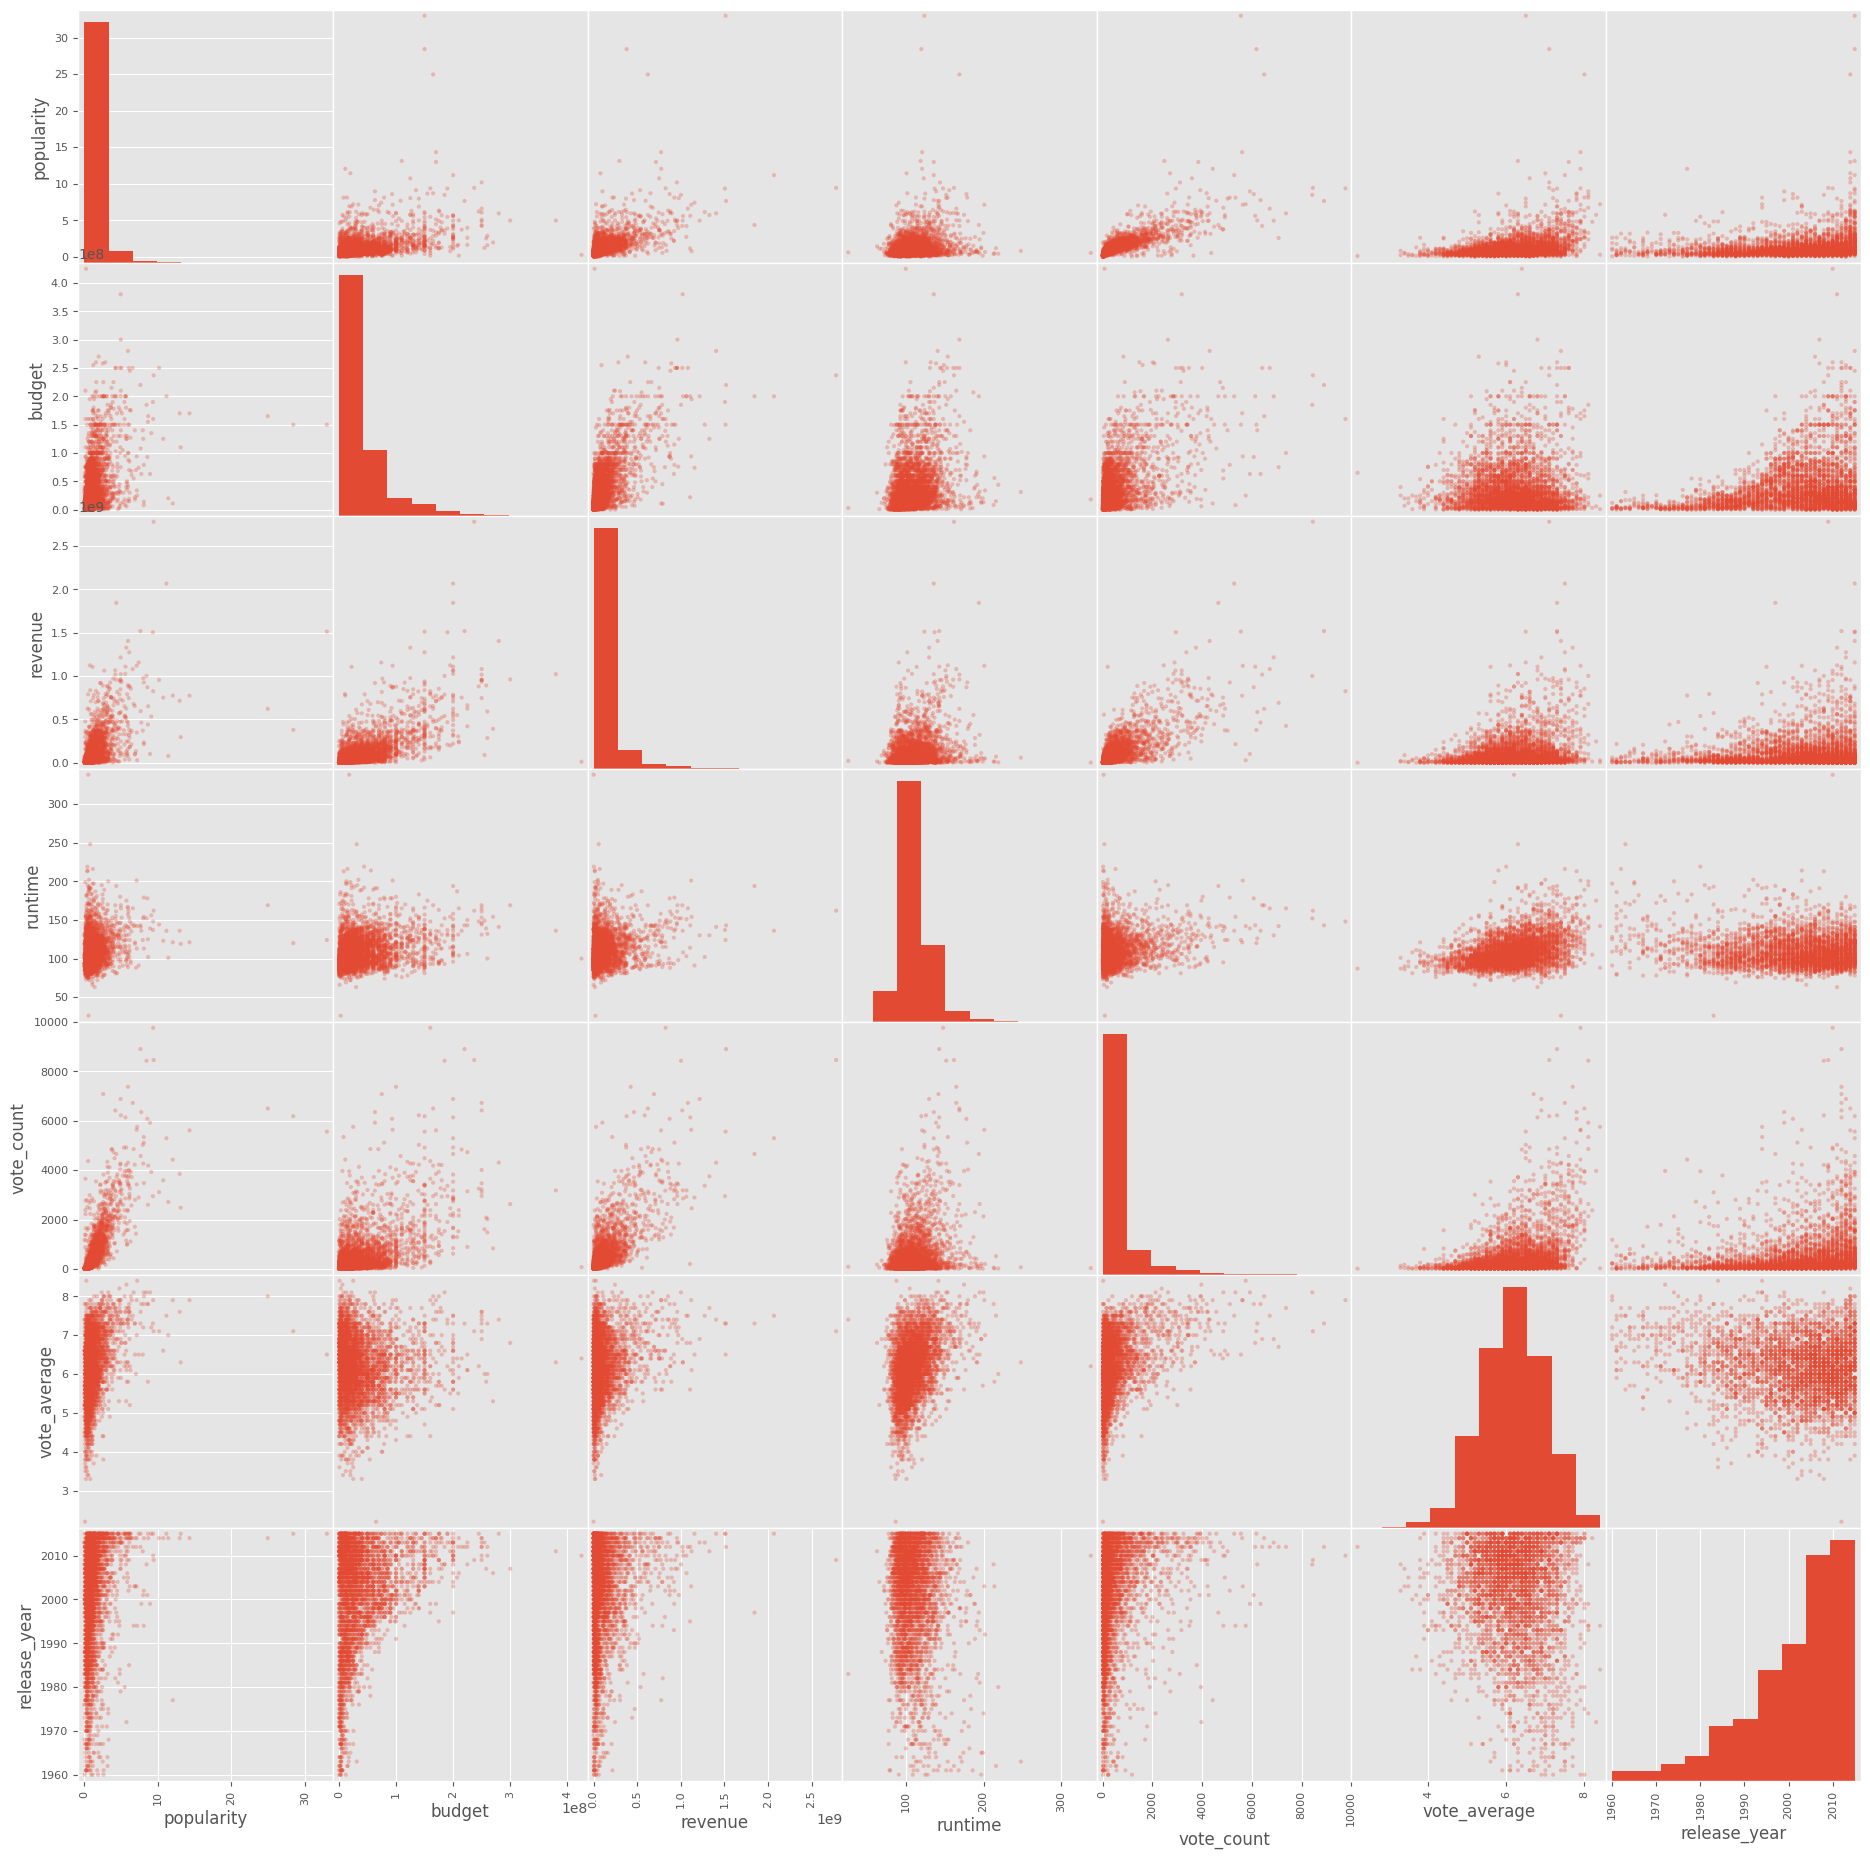

In [12]:
pd.plotting.scatter_matrix(desired_columns_df.drop(columns=['id']), alpha=0.3, figsize=(23,23), grid=True)
plt.show()

In [13]:
desired_columns_df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year
count,3755.000000,3755.000000,3.755000e+03,3.755000e+03,3755.000000,3755.000000,3755.000000,3755.000000
mean,39838.926764,1.213310,3.799931e+07,1.103892e+08,109.490812,539.935020,6.175499,2001.216511
std,67550.221487,1.487692,4.241056e+07,1.780367e+08,19.804024,888.043338,0.789868,11.343653
min,5.000000,0.010335,1.200000e+04,1.028900e+04,26.000000,10.000000,2.200000,1960.000000
25%,5915.500000,0.475636,1.000000e+07,1.489688e+07,96.000000,75.000000,5.700000,1995.000000
50%,11217.000000,0.822880,2.500000e+07,4.735125e+07,106.000000,214.000000,6.200000,2004.000000
75%,38360.500000,1.395678,5.000000e+07,1.282480e+08,119.000000,589.500000,6.700000,2010.000000
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000


In [14]:
desired_columns_df.select_dtypes(include='number').median()

id              1.121700e+04
popularity      8.228800e-01
budget          2.500000e+07
revenue         4.735125e+07
runtime         1.060000e+02
vote_count      2.140000e+02
vote_average    6.200000e+00
release_year    2.004000e+03
dtype: float64

## Векторизация
Приведение строк, разделенных символом "|", к бинарным векторам с помощью CountVectorizer из библиотеки scikit-learn

#### 1. Векторизация режиссеров

In [15]:
def tokenize(text):
    """Функция токенизации"""
    return text.split('|')

directors_vectorizer = CountVectorizer(tokenizer=tokenize)
directors_data = pd.DataFrame(directors_vectorizer.fit_transform(desired_columns_df['director']).toarray(), index=desired_columns_df.id, 
                              columns=directors_vectorizer.get_feature_names_out())

directors_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,aaron seltzer,abbas tyrewala,abe sylvia,abel ferrara,adam green,adam mckay,adam rifkin,adam shankman,adam wingard,adrian lyne,...,xavier dolan,xavier gens,xavier palud,yorgos lanthimos,yvan attal,zach braff,zack snyder,zal batmanglij,zillah bowes,ã‰mile gaudreault
id,,,,,,,,,,,,,,,,,,,,,
135397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. Векторизация актеров

In [16]:
cast_vectorizer = CountVectorizer(tokenizer=tokenize)
cast_data = pd.DataFrame(cast_vectorizer.fit_transform(desired_columns_df['cast']).toarray(), index=desired_columns_df.id, 
                     columns=cast_vectorizer.get_feature_names_out())
cast_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,50 cent,a martinez,a. michael baldwin,a.j. cook,aaliyah,aamir khan,aaran thomas,aaron abrams,aaron burns,aaron eckhart,...,zoie palmer,zooey deschanel,zoã« bell,zoã« borde,zoã« kravitz,zuleikha robinson,à¸ªà¸£à¸žà¸‡à¸©à¹œ à¸šà¸²à¸•à¸£à¸µ,ãngela molina,ã“lafur darri ã“lafsson,äá»— thá»‹ háº£i yáº¿n
id,,,,,,,,,,,,,,,,,,,,,
135397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3. Векторизация продакшн компаний

In [17]:
prod_vectorizer = CountVectorizer(tokenizer=tokenize)
prod_data = pd.DataFrame(prod_vectorizer.fit_transform(desired_columns_df['production_companies']).toarray(), index=desired_columns_df.id, 
                     columns=prod_vectorizer.get_feature_names_out())
prod_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,"""dia"" productions gmbh & co. kg",1019 entertainment,10th hole productions,11:11 mediaworks,120db films,1492 pictures,1818,1821 pictures,1984 private defense contractors,2 entertain,...,zininsa film production,zippcast films,zoetrope argentina,zoetrope studios,zohar international,zone productions,zucker brothers productions,zucker/netter productions,zupnik cinema group ii,zweites deutsches fernsehen (zdf)
id,,,,,,,,,,,,,,,,,,,,,
135397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 4. Векторизация жанров

In [18]:
genre_vectorizer = CountVectorizer(tokenizer=tokenize)
genre_data = pd.DataFrame(genre_vectorizer.fit_transform(desired_columns_df['genres']).toarray(), index=desired_columns_df.id, 
                     columns=genre_vectorizer.get_feature_names_out())
genre_data.head(2)

C:\Users\Тимур\Desktop\movie_practice\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
id,,,,,,,,,,,,,,,,,,,,
135397,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
76341,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


# Способы разделения данных и визуализация

### 1. По количеству фильмов у режиссера

In [19]:
movie_by_director = desired_columns_df.groupby('director', as_index=False).agg({'original_title': 'count'})\
                                                        .sort_values('original_title', ascending=False)[:5]

movie_by_director

,director,original_title
1490,Steven Spielberg,27
257,Clint Eastwood,24
1277,Ridley Scott,21
1640,Woody Allen,18
997,Martin Scorsese,17


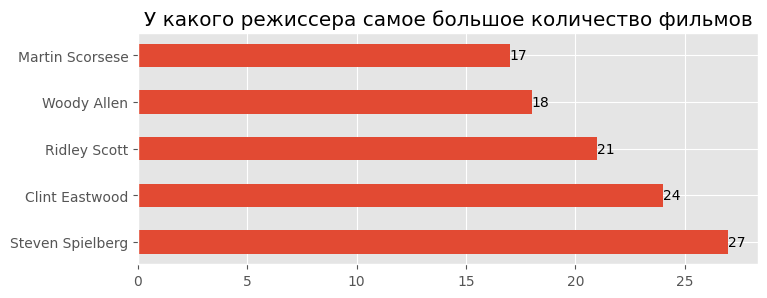

In [20]:
movie_by_director_bars = plt.barh(movie_by_director['director'], movie_by_director['original_title'], 0.5)

plt.bar_label(movie_by_director_bars, )
plt.title('У какого режиссера самое большое количество фильмов')
plt.show()

### 2. По экономической целесообразности

In [21]:
revenue_by_year_max = desired_columns_df.groupby('release_year', as_index=False).agg({'revenue': 'sum'})\
                                                            .sort_values('revenue', ascending=False)
budget_by_year = desired_columns_df.groupby('release_year', as_index=False).agg({'budget': 'sum'})\
                                                            .sort_values('budget', ascending=False)
revenue_by_year_max.head(2)

,release_year,revenue
55,2015,26202922801
53,2013,24349444844


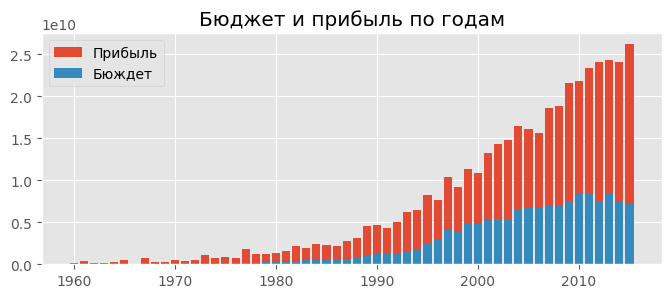

In [22]:
plt.title('Бюджет и прибыль по годам')
plt.bar(revenue_by_year_max['release_year'], revenue_by_year_max['revenue'], label='Прибыль')
plt.bar(budget_by_year['release_year'], budget_by_year['budget'], label='Бюждет')
plt.legend()
plt.show()

In [23]:
revenue_by_year_min = desired_columns_df.groupby('release_year', as_index=False).agg({'revenue': 'sum'})\
                                                            .sort_values('revenue', ascending=True)[:5]
revenue_by_year_min

,release_year,revenue
6,1966,84736689
0,1960,129005000
3,1963,176526882
2,1962,206329846
8,1968,222221762


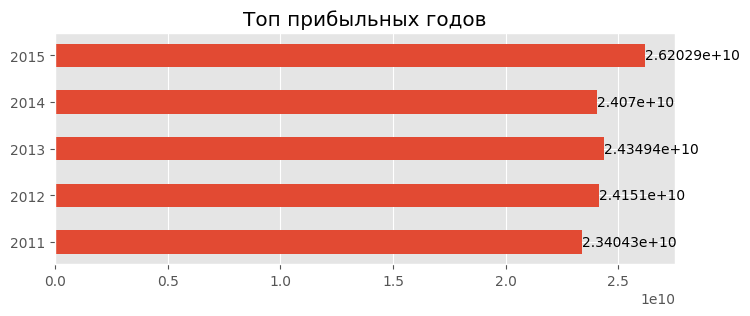

In [24]:
revenue_by_year_max_bars = plt.barh(revenue_by_year_max[:5]['release_year'], revenue_by_year_max[:5]['revenue'], 0.5)

plt.bar_label(revenue_by_year_max_bars)
plt.title('Топ прибыльных годов')
plt.show()

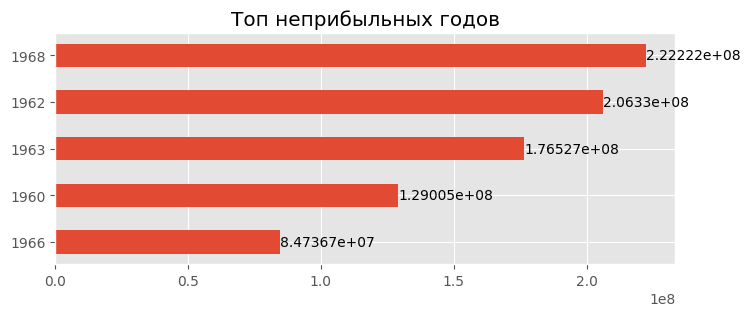

In [25]:
years_ticks = [str(year) for year in revenue_by_year_min['release_year']]

revenue_by_year_min_bars = plt.barh(years_ticks, revenue_by_year_min['revenue'], 0.5)
plt.bar_label(revenue_by_year_min_bars)
plt.title('Топ неприбыльных годов')
plt.show()

In [26]:
revenue_by_title_max = desired_columns_df.sort_values('revenue', ascending=False)[:10][['original_title', 'budget', 'revenue']][:10]
revenue_by_title_max

,original_title,budget,revenue
1386,Avatar,237000000,2781505847
3,Star Wars: The Force Awakens,200000000,2068178225
5231,Titanic,200000000,1845034188
4361,The Avengers,220000000,1519557910
0,Jurassic World,150000000,1513528810
4,Furious 7,190000000,1506249360
14,Avengers: Age of Ultron,280000000,1405035767
3374,Harry Potter and the Deathly Hallows: Part 2,125000000,1327817822
5422,Frozen,150000000,1274219009
5425,Iron Man 3,200000000,1215439994


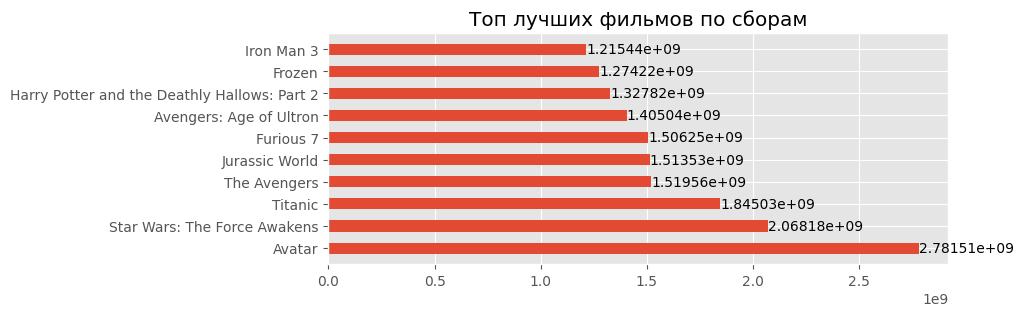

In [27]:
revenue_by_title_max_bars = plt.barh(revenue_by_title_max['original_title'], revenue_by_title_max['revenue'], 0.5)

plt.bar_label(revenue_by_title_max_bars)
plt.title('Топ лучших фильмов по сборам')
plt.show()

### 3. По популярности фильмов

In [28]:
popularity_title_max = desired_columns_df.sort_values('popularity', ascending=False)[:10][['original_title', 'popularity']]
popularity_title_max

,original_title,popularity
0,Jurassic World,32.985763
1,Mad Max: Fury Road,28.419936
629,Interstellar,24.949134
630,Guardians of the Galaxy,14.311205
2,Insurgent,13.112507
631,Captain America: The Winter Soldier,12.971027
1329,Star Wars,12.037933
632,John Wick,11.422751
3,Star Wars: The Force Awakens,11.173104
633,The Hunger Games: Mockingjay - Part 1,10.739009


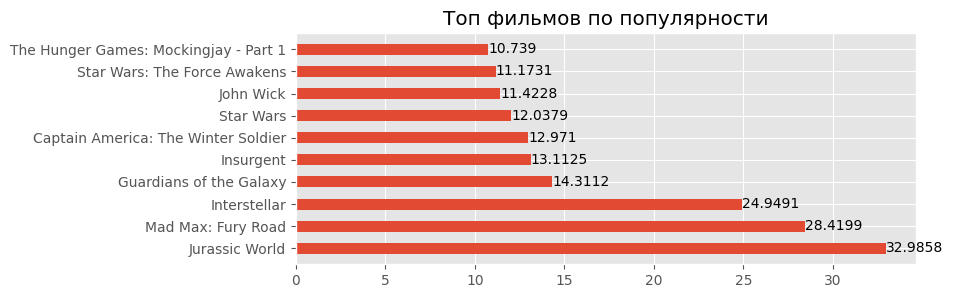

In [29]:
popularity_title_max_bars = plt.barh(popularity_title_max['original_title'], popularity_title_max['popularity'], 0.5)

plt.bar_label(popularity_title_max_bars)
plt.title('Топ фильмов по популярности')
plt.show()

### 4. По оценкам фильмов

In [25]:
rating_title = desired_columns_df\
.sort_values(['vote_average'], ascending=False)[:10][['original_title', 'vote_average']][:10]

rating_title

,original_title,vote_average
4178,The Shawshank Redemption,8.4
7948,Stop Making Sense,8.4
7269,The Godfather,8.3
650,Whiplash,8.2
2875,The Dark Knight,8.1
10222,Schindler's List,8.1
9758,The Godfather: Part II,8.1
2409,Fight Club,8.1
4177,Pulp Fiction,8.1
4179,Forrest Gump,8.1


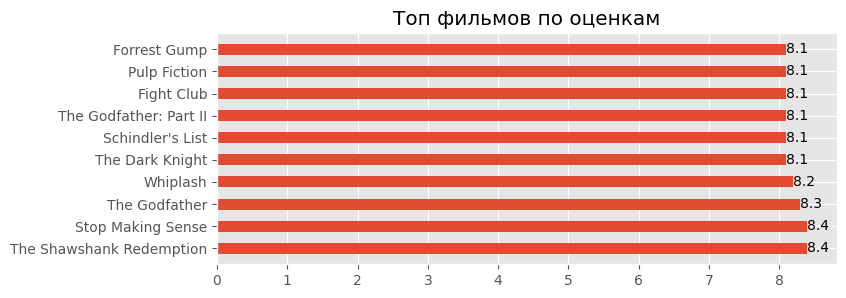

In [26]:
rating_title_bars = plt.barh(rating_title['original_title'], rating_title['vote_average'], 0.5)

plt.bar_label(rating_title_bars)
plt.title('Топ фильмов по оценкам')
plt.show()

### 5. По количеству оценок

In [27]:
vote_count_by_title = desired_columns_df\
                                .sort_values(['vote_count'], ascending=False)[:10][['original_title', 'vote_count']][:10]

vote_count_by_title

,original_title,vote_count
1919,Inception,9767
4361,The Avengers,8903
1386,Avatar,8458
2875,The Dark Knight,8432
4364,Django Unchained,7375
4382,The Hunger Games,7080
5425,Iron Man 3,6882
4363,The Dark Knight Rises,6723
629,Interstellar,6498
4367,The Hobbit: An Unexpected Journey,6417


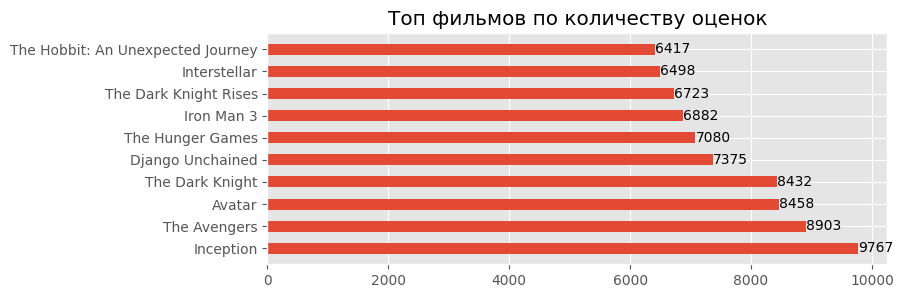

In [28]:
vote_count_by_title_bars = plt.barh(vote_count_by_title['original_title'], vote_count_by_title['vote_count'], 0.5)

plt.bar_label(vote_count_by_title_bars)
plt.title('Топ фильмов по количеству оценок')
plt.show()

### 6. Количество фильмов в жанрах

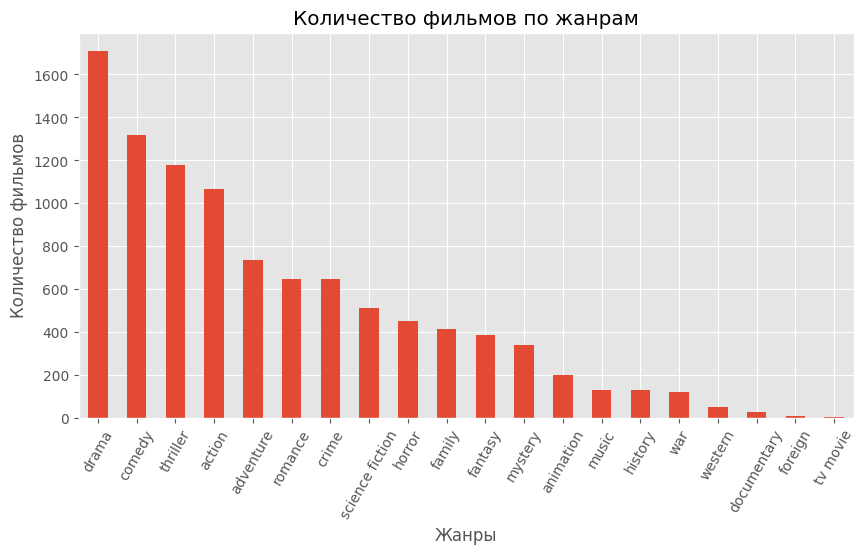

In [41]:
plt.figure(figsize=(10, 5))
genre_data_sum = genre_data.sum().sort_values(ascending=False)
genre_data_sum.plot(kind='bar')  
plt.title('Количество фильмов по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=60)
plt.show()

### 7. В скольких фильмах снимались актеры

In [125]:
cast_revenue_df = desired_columns_df[['original_title']].merge(cast_data, on=desired_columns_df.index)
cast_revenue_df.pop('key_0')
cast_revenue_df.tail(3)

,original_title,50 cent,a martinez,a. michael baldwin,a.j. cook,aaliyah,aamir khan,aaran thomas,aaron abrams,aaron burns,...,zoie palmer,zooey deschanel,zoã« bell,zoã« borde,zoã« kravitz,zuleikha robinson,à¸ªà¸£à¸žà¸‡à¸©à¹œ à¸šà¸²à¸•à¸£à¸µ,ãngela molina,ã“lafur darri ã“lafsson,äá»— thá»‹ háº£i yáº¿n
3752,El Dorado,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3753,The Sand Pebbles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3754,Fantastic Voyage,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
cast_revenue_df.set_index('original_title', inplace=True)
cast_revenue_df = cast_revenue_df.transpose()
cast_revenue_df.reset_index(inplace=True)
cast_revenue_df.rename(columns={'index': 'actors'}, inplace=True)
cast_revenue_df

original_title,actors,Jurassic World,Mad Max: Fury Road,Insurgent,Star Wars: The Force Awakens,Furious 7,The Revenant,Terminator Genisys,The Martian,Minions,...,Convoy,Invasion of the Body Snatchers,The Wiz,Damien: Omen II,Watership Down,Who's Afraid of Virginia Woolf?,Torn Curtain,El Dorado,The Sand Pebbles,Fantastic Voyage
0,50 cent,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,a martinez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,a. michael baldwin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,a.j. cook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aaliyah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6647,zuleikha robinson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6648,à¸ªà¸£à¸žà¸‡à¸©à¹œ à¸šà¸²à¸•à¸£à¸µ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6649,ãngela molina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6650,ã“lafur darri ã“lafsson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
cast_revenue_df['total_movie'] = cast_revenue_df.iloc[:, 1:].sum(axis=1)
cast_revenue_df.head(3)

original_title,actors,Jurassic World,Mad Max: Fury Road,Insurgent,Star Wars: The Force Awakens,Furious 7,The Revenant,Terminator Genisys,The Martian,Minions,...,Invasion of the Body Snatchers,The Wiz,Damien: Omen II,Watership Down,Who's Afraid of Virginia Woolf?,Torn Curtain,El Dorado,The Sand Pebbles,Fantastic Voyage,total_movie
0,50 cent,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,a martinez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,a. michael baldwin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [128]:
sorted_cast_revenue_df = cast_revenue_df.sort_values('total_movie', ascending=False) 
sorted_cast_revenue_df.head(2)

original_title,actors,Jurassic World,Mad Max: Fury Road,Insurgent,Star Wars: The Force Awakens,Furious 7,The Revenant,Terminator Genisys,The Martian,Minions,...,Invasion of the Body Snatchers,The Wiz,Damien: Omen II,Watership Down,Who's Afraid of Virginia Woolf?,Torn Curtain,El Dorado,The Sand Pebbles,Fantastic Voyage,total_movie
5360,robert de niro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52
856,bruce willis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,46


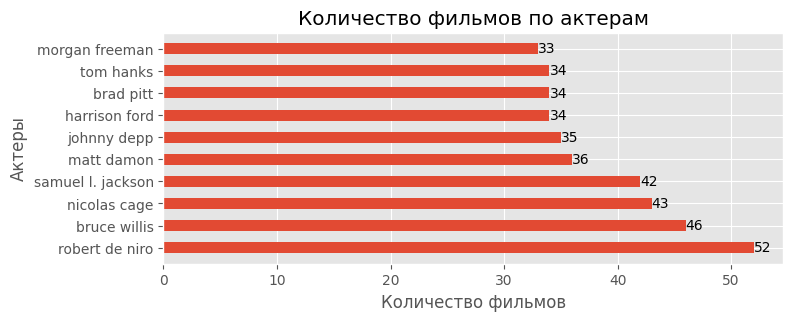

In [132]:
plt.title('Количество фильмов по актерам')
movie_count_by_cast = plt.barh(sorted_cast_revenue_df[:10]['actors'], sorted_cast_revenue_df[:10]['total_movie'], 0.5)
plt.bar_label(movie_count_by_cast)
plt.xlabel('Количество фильмов')
plt.ylabel('Актеры')
plt.show()

# Корреляция бюджета и сборов

In [29]:
budget_revenue_corr = desired_columns_df[['budget', 'revenue']].corr()
budget_revenue_corr.style.background_gradient(cmap='RdYlGn')

,budget,revenue
budget,1.000000,0.686321
revenue,0.686321,1.000000


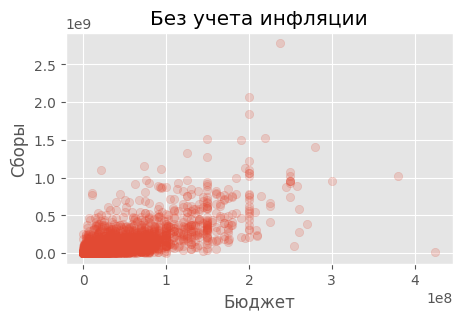

In [30]:
plt.figure(figsize=(5, 3))
plt.scatter(desired_columns_df['budget'], desired_columns_df['revenue'], alpha=0.2)
plt.title('Без учета инфляции')
plt.xlabel('Бюджет')
plt.ylabel('Cборы')
plt.show()

# Простая линейная регрессия
# $$ Y=a+b*x $$ 
### где \\(a\\)- сдвиг линии по оси \\(y\\), \\(b\\)- наклон линии.

In [31]:
X = pd.DataFrame(desired_columns_df['budget'])
Y = pd.DataFrame(desired_columns_df['revenue'])
linear_reg_revenue = LinearRegression()
linear_reg_revenue.fit(X, Y)

LinearRegression()

In [32]:
linear_reg_revenue.coef_

array([[2.88113075]])

#### Линейная регрессия показала плохой результат

In [33]:
linear_reg_revenue.score(X, Y)

0.47103684184610284

# Визуализация линейной регрессии

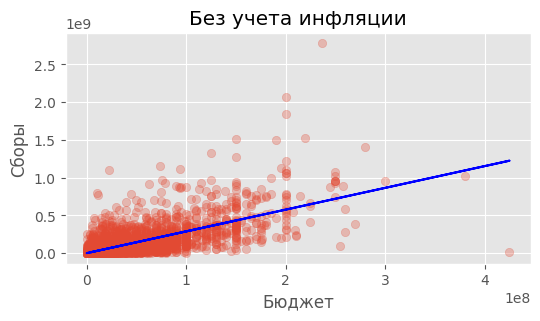

In [34]:
x, y = desired_columns_df['budget'], desired_columns_df['revenue']
plt.figure(figsize=(6, 3))
plt.title('Без учета инфляции')
plt.scatter(x, y, alpha=0.3)
plt.plot(x, linear_reg_revenue.predict(X), color='blue')
plt.xlabel('Бюджет')
plt.ylabel('Cборы')
plt.show()

In [64]:
budget_revenue_corr = desired_columns_df[['vote_count', 'popularity', 'vote_average']].corr()
budget_revenue_corr.style.background_gradient(cmap='RdYlGn')

,vote_count,popularity,vote_average
vote_count,1.000000,0.778426,0.390525
popularity,0.778426,1.000000,0.320656
vote_average,0.390525,0.320656,1.000000


In [185]:
indexes = [0, 1, 2]
df_for_multiple_reg = desired_columns_df.iloc[:, indexes]
df_for_multiple_reg.head()

,id,popularity,budget
0,135397,32.985763,150000000
1,76341,28.419936,150000000
2,262500,13.112507,110000000
3,140607,11.173104,200000000
4,168259,9.335014,190000000


In [191]:
# Добавить режиссеров в датафрейм
prepared_df_for_multiple_reg = df_for_multiple_reg.merge(directors_data, on=df_for_multiple_reg.index)
prepared_df_for_multiple_reg.pop('key_0')
# Добавить актеров в датафрейм
# prepared_df_for_multiple_reg = prepared_df_for_multiple_reg.merge(cast_data, on=df_for_multiple_reg.index)
# prepared_df_for_multiple_reg.pop('key_0')
# Добавить продакшн-компании в датафрейм
# prepared_df_for_multiple_reg = prepared_df_for_multiple_reg.merge(prod_data, on=df_for_multiple_reg.index)
# prepared_df_for_multiple_reg.pop('key_0')
# Добавить жанры в датафрейм
# prepared_df_for_multiple_reg = prepared_df_for_multiple_reg.merge(genre_data, on=df_for_multiple_reg.index)
# prepared_df_for_multiple_reg.pop('key_0')
prepared_df_for_multiple_reg.head(5)

,id,popularity,budget,aaron seltzer,abbas tyrewala,abe sylvia,abel ferrara,adam green,adam mckay,adam rifkin,...,xavier dolan,xavier gens,xavier palud,yorgos lanthimos,yvan attal,zach braff,zack snyder,zal batmanglij,zillah bowes,ã‰mile gaudreault
0,135397,32.985763,150000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,76341,28.419936,150000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,262500,13.112507,110000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,140607,11.173104,200000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,168259,9.335014,190000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
revenue = desired_columns_df['revenue']
features = prepared_df_for_multiple_reg.drop(columns=['id'])
X_train, X_test, y_train, y_test = train_test_split(features, revenue, test_size=0.2, random_state=20)

# Множественная линейная регрессия
# $$ Y = a + b1*x1 + b2*x2 + ... + bp*xp $$

In [188]:
multiple_reg = LinearRegression()
multiple_reg.fit(X_train, y_train)

LinearRegression()

In [189]:
print(multiple_reg.score(X_train, y_train))
print(multiple_reg.score(X_test, y_test))

0.7759087855724378
0.43054989993645854


In [ ]:
multiple_reg.coef_

# Метод случайного леса

In [53]:
random_forest = RandomForestRegressor(n_estimators=250, max_features ='sqrt').fit(X_train, y_train)

#### Результат намного лучше, чем у линейной регрессии

In [54]:
print(random_forest.score(X_train, y_train))
print(random_forest.score(X_test, y_test))

0.9556444935303994
0.6172815948146947
